In [2]:
import sys

# Cài toàn bộ thư viện cần cho bài LeNet
!"{sys.executable}" -m pip install numpy matplotlib scikit-learn "tensorflow==2.15.0"

   ---------------------------------------- 0.0/300.9 MB ? eta -:--:--
   ---------------------------------------- 1.3/300.9 MB 7.4 MB/s eta 0:00:41
   ---------------------------------------- 3.4/300.9 MB 8.8 MB/s eta 0:00:34
    --------------------------------------- 5.2/300.9 MB 8.6 MB/s eta 0:00:35
    --------------------------------------- 6.8/300.9 MB 8.7 MB/s eta 0:00:34
   - -------------------------------------- 8.9/300.9 MB 8.8 MB/s eta 0:00:34
   - -------------------------------------- 11.3/300.9 MB 9.4 MB/s eta 0:00:31
   - -------------------------------------- 14.2/300.9 MB 9.9 MB/s eta 0:00:30
   -- ------------------------------------- 16.3/300.9 MB 9.9 MB/s eta 0:00:29
   -- ------------------------------------- 18.9/300.9 MB 10.3 MB/s eta 0:00:28
   -- ------------------------------------- 22.0/300.9 MB 10.7 MB/s eta 0:00:27
   --- ------------------------------------ 24.4/300.9 MB 10.8 MB/s eta 0:00:26
   --- ------------------------------------ 28.0/300.9 MB 11.4

Thiết lập môi trường & import thư viện 

In [40]:
import os
import numpy as np
import matplotlib.pyplot as plt
import zipfile
from PIL import Image
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report

# Thiết lập seed
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.15.0


Tải & Chuẩn bị dữ liệu VinaFood21

Dữ liệu đã được giải nén trước đó.
✓ Tìm thấy thư mục train: VinaFood21_data\VinaFood21\train
✓ Tìm thấy thư mục test: VinaFood21_data\VinaFood21\test
Found 8042 images belonging to 21 classes.
Found 2002 images belonging to 21 classes.
Found 6682 images belonging to 21 classes.

THÔNG TIN DATASET
Số lượng lớp: 21
Tên các lớp: ['banh-can', 'banh-hoi', 'banh-mi-chao', 'banh-tet', 'banh-trang-tron', 'banh-u', 'banh-uot', 'bap-nuong', 'bo-kho', 'bo-la-lot', 'bot-chien', 'ca-ri', 'canh-kho-qua', 'canh-khoai-mo', 'ga-nuong', 'goi-ga', 'ha-cao', 'hoanh-thanh-nuoc', 'pha-lau', 'tau-hu', 'thit-kho-trung']
Số ảnh training: 8042
Số ảnh validation: 2002
Số ảnh test: 6682

PHÂN BỐ DỮ LIỆU THEO CLASS

Class                Train      Test      
----------------------------------------
banh-can             363        241       
banh-hoi             910        607       
banh-mi-chao         434        289       
banh-tet             548        364       
banh-trang-tron      465        309       
ban

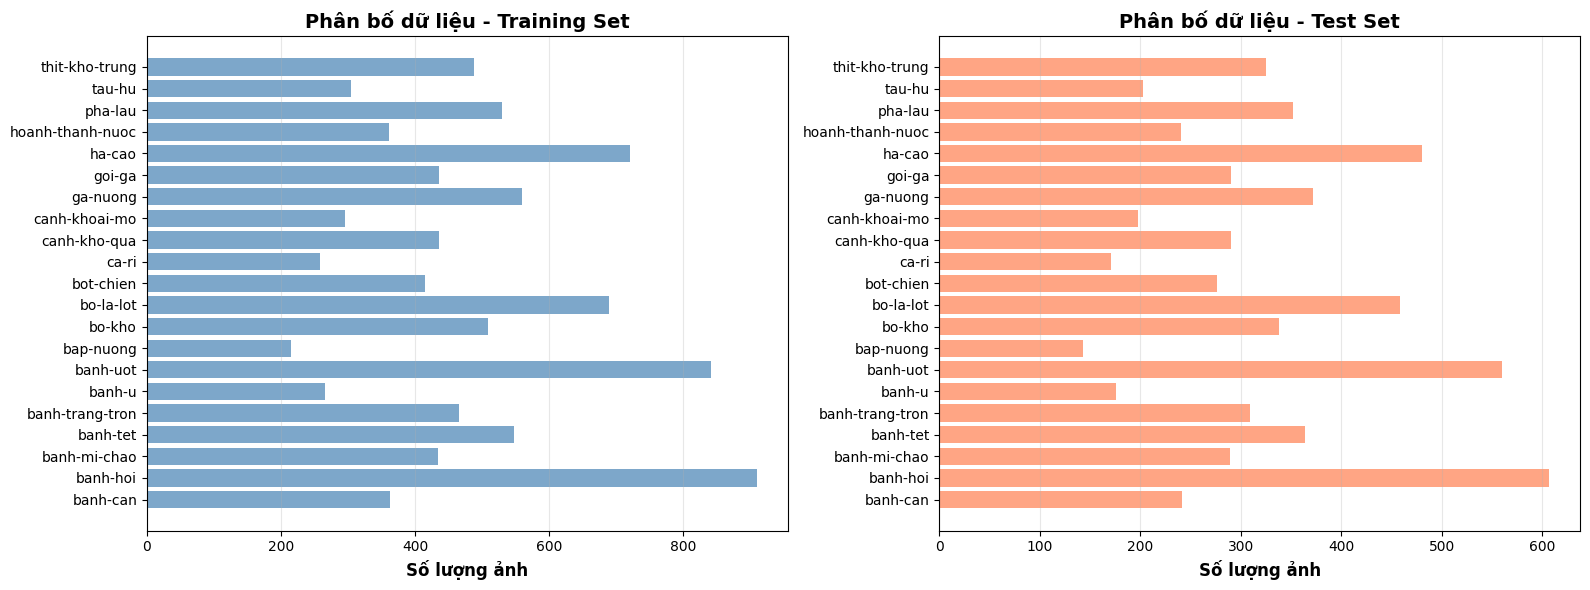


✓ Đã lưu biểu đồ phân bố dữ liệu vào 'data_distribution.png'

KIỂM TRA KÍCH THƯỚC ẢNH GỐC
Kiểm tra 10 ảnh mẫu từ class 'banh-can':
  Ảnh 1: 1080x1080 pixels
  Ảnh 2: 1080x1080 pixels
  Ảnh 3: 1080x1080 pixels
  Ảnh 4: 1080x1080 pixels
  Ảnh 5: 1080x864 pixels
  Ảnh 6: 1080x1080 pixels
  Ảnh 7: 1080x1080 pixels
  Ảnh 8: 1080x1080 pixels
  Ảnh 9: 936x1170 pixels
  Ảnh 10: 1080x1080 pixels

Kích thước trung bình: 1066x1067 pixels
Kích thước sau resize: 224x224 pixels (cho LeNet)


In [41]:
# Đường dẫn tới file zip
zip_path = 'VinaFood21.zip'
extract_path = 'VinaFood21_data'

# Giải nén file zip (nếu chưa giải nén)
if not os.path.exists(extract_path):
    print("Đang giải nén dữ liệu...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print("Hoàn tất giải nén!")
else:
    print("Dữ liệu đã được giải nén trước đó.")

# Tìm thư mục chứa dữ liệu train/test
# Đường dẫn: VinaFood21_data/VinaFood21/train và VinaFood21_data/VinaFood21/test
data_dir = os.path.join(extract_path, 'VinaFood21')

# Kiểm tra đường dẫn có đúng không
train_path = os.path.join(data_dir, 'train')
test_path = os.path.join(data_dir, 'test')

if not os.path.exists(train_path):
    print(f"⚠ CẢNH BÁO: Không tìm thấy thư mục train tại {train_path}")
    print("Vui lòng kiểm tra lại cấu trúc thư mục!")
else:
    print(f"✓ Tìm thấy thư mục train: {train_path}")
    
if not os.path.exists(test_path):
    print(f"⚠ CẢNH BÁO: Không tìm thấy thư mục test tại {test_path}")
else:
    print(f"✓ Tìm thấy thư mục test: {test_path}")

# Thiết lập thông số ảnh
img_height = 224
img_width = 224
batch_size = 32

# Tạo data generators với augmentation cho training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1,
    validation_split=0.2  # Chia 20% làm validation
)

# Generator riêng cho test (chỉ rescale, không augmentation)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load dữ liệu training
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=42  # Thêm seed cho reproducibility
)

# Load dữ liệu validation
validation_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False,
    seed=42  # Cùng seed để đảm bảo split nhất quán
)

# Load dữ liệu test
test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# In thông tin về dataset
print(f"\n{'='*70}")
print(f"THÔNG TIN DATASET")
print(f"{'='*70}")
print(f"Số lượng lớp: {train_generator.num_classes}")
print(f"Tên các lớp: {list(train_generator.class_indices.keys())}")
print(f"Số ảnh training: {train_generator.samples}")
print(f"Số ảnh validation: {validation_generator.samples}")
print(f"Số ảnh test: {test_generator.samples}")

# Kiểm tra kích thước ảnh và số lượng ảnh mỗi class
print(f"\n{'='*70}")
print(f"PHÂN BỐ DỮ LIỆU THEO CLASS")
print(f"{'='*70}")

# Đếm số lượng ảnh trong mỗi class (training set)
class_counts_train = {}
for class_name in train_generator.class_indices.keys():
    class_path = os.path.join(train_path, class_name)
    if os.path.exists(class_path):
        num_images = len([f for f in os.listdir(class_path) 
                         if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
        class_counts_train[class_name] = num_images

# Đếm số lượng ảnh trong mỗi class (test set)
class_counts_test = {}
for class_name in test_generator.class_indices.keys():
    class_path = os.path.join(test_path, class_name)
    if os.path.exists(class_path):
        num_images = len([f for f in os.listdir(class_path) 
                         if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
        class_counts_test[class_name] = num_images

# Hiển thị bảng phân bố
print(f"\n{'Class':<20} {'Train':<10} {'Test':<10}")
print(f"{'-'*40}")
for class_name in sorted(train_generator.class_indices.keys()):
    train_count = class_counts_train.get(class_name, 0)
    test_count = class_counts_test.get(class_name, 0)
    print(f"{class_name:<20} {train_count:<10} {test_count:<10}")

print(f"{'-'*40}")
print(f"{'TỔNG':<20} {sum(class_counts_train.values()):<10} {sum(class_counts_test.values()):<10}")

# Vẽ biểu đồ phân bố
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Biểu đồ training set
axes[0].barh(list(class_counts_train.keys()), list(class_counts_train.values()), 
             color='steelblue', alpha=0.7)
axes[0].set_xlabel('Số lượng ảnh', fontsize=12, fontweight='bold')
axes[0].set_title('Phân bố dữ liệu - Training Set', fontsize=14, fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)

# Biểu đồ test set
axes[1].barh(list(class_counts_test.keys()), list(class_counts_test.values()), 
             color='coral', alpha=0.7)
axes[1].set_xlabel('Số lượng ảnh', fontsize=12, fontweight='bold')
axes[1].set_title('Phân bố dữ liệu - Test Set', fontsize=14, fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('data_distribution.png', dpi=150, bbox_inches='tight')
plt.show()
print("\n✓ Đã lưu biểu đồ phân bố dữ liệu vào 'data_distribution.png'")

# Kiểm tra kích thước ảnh gốc
print(f"\n{'='*70}")
print(f"KIỂM TRA KÍCH THƯỚC ẢNH GỐC")
print(f"{'='*70}")

sample_sizes = []
sample_class = list(train_generator.class_indices.keys())[0]
sample_class_path = os.path.join(train_path, sample_class)
sample_files = [f for f in os.listdir(sample_class_path) 
                if f.lower().endswith(('.png', '.jpg', '.jpeg'))][:10]

for img_file in sample_files:
    img_path = os.path.join(sample_class_path, img_file)
    img = Image.open(img_path)
    sample_sizes.append(img.size)

print(f"Kiểm tra 10 ảnh mẫu từ class '{sample_class}':")
for i, size in enumerate(sample_sizes, 1):
    print(f"  Ảnh {i}: {size[0]}x{size[1]} pixels")

# Tính kích thước trung bình
avg_width = sum([s[0] for s in sample_sizes]) / len(sample_sizes)
avg_height = sum([s[1] for s in sample_sizes]) / len(sample_sizes)
print(f"\nKích thước trung bình: {avg_width:.0f}x{avg_height:.0f} pixels")
print(f"Kích thước sau resize: {img_width}x{img_height} pixels (cho LeNet)")


Hiển thị vài mẫu ảnh


HIỂN THỊ MẪU ẢNH TỪ TẬP TRAINING


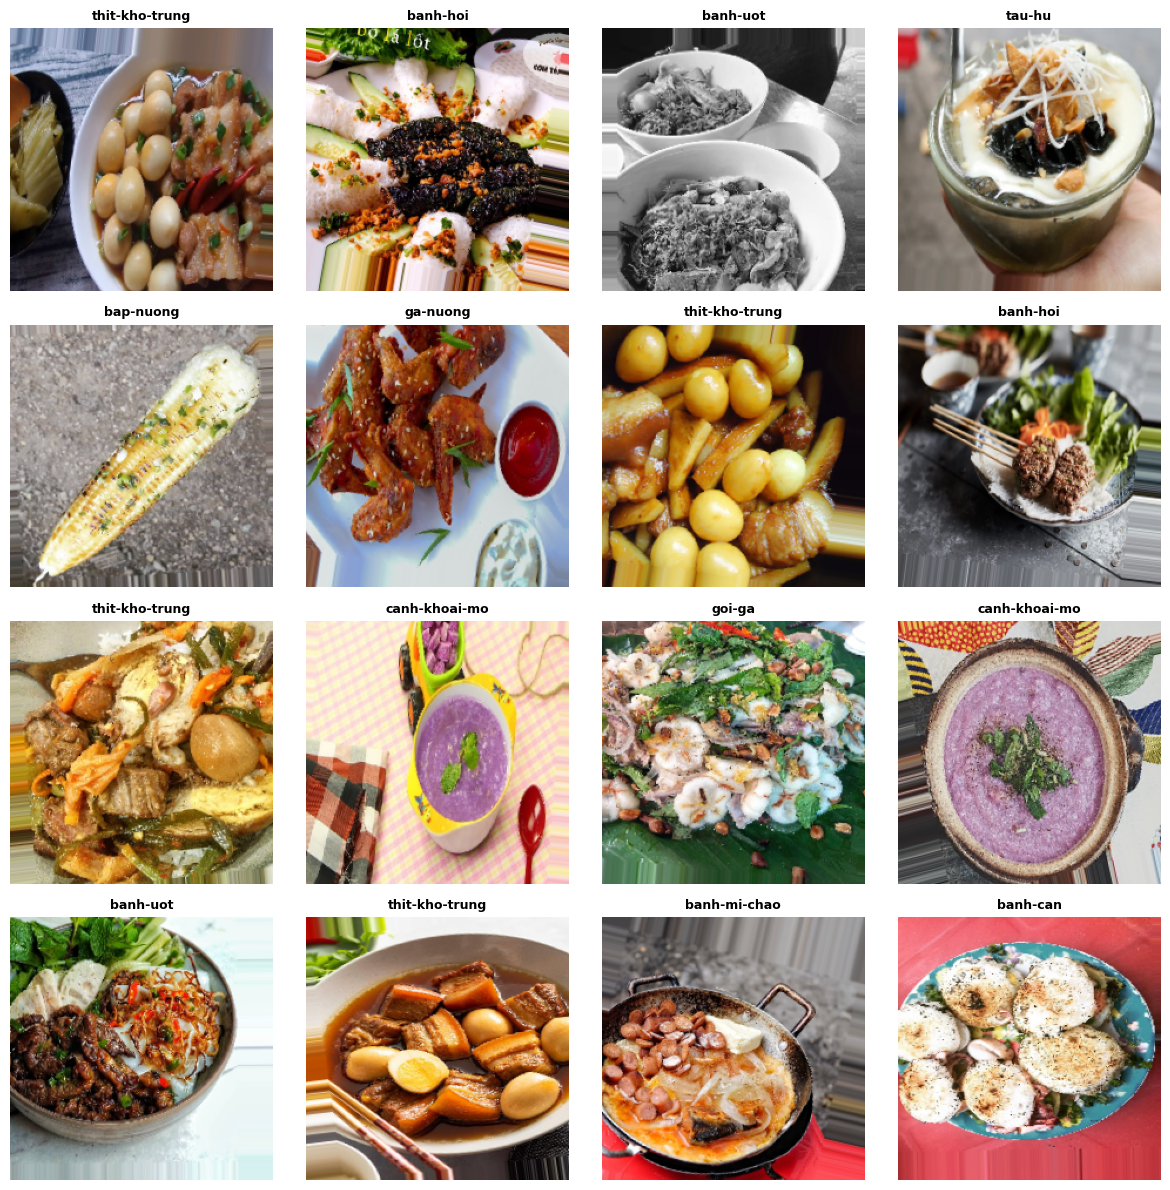


✓ Đã lưu ảnh mẫu vào 'sample_images.png'


In [42]:
# Lấy danh sách tên các class
class_names = list(train_generator.class_indices.keys())

# Lấy một batch ảnh để hiển thị
sample_batch_x, sample_batch_y = next(train_generator)
train_generator.reset()  # Reset về đầu

print(f"\n{'='*70}")
print(f"HIỂN THỊ MẪU ẢNH TỪ TẬP TRAINING")
print(f"{'='*70}")

plt.figure(figsize=(12, 12))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(sample_batch_x[i])
    
    # Lấy label từ one-hot encoding
    label_idx = np.argmax(sample_batch_y[i])
    plt.title(class_names[label_idx], fontsize=9, fontweight='bold')
    plt.axis("off")

plt.tight_layout()
plt.savefig('sample_images.png', dpi=150, bbox_inches='tight')
plt.show()
print("\n✓ Đã lưu ảnh mẫu vào 'sample_images.png'")

Bài 1: Xây dựng mô hình LeNet

In [43]:
def build_lenet(input_shape=(64, 64, 3), num_classes=21):
    model = models.Sequential()
    
    # C1: Conv 5x5, 6 filters
    model.add(layers.Conv2D(6, (5, 5), padding="same", 
                            activation="relu", input_shape=input_shape))
    model.add(layers.AveragePooling2D((2, 2), strides=2))
    
    # C2: Conv 5x5, 16 filters
    model.add(layers.Conv2D(16, (5, 5), padding="valid", activation="relu"))
    model.add(layers.AveragePooling2D((2, 2), strides=2))
    
    # C3: Conv 3x3, 32 filters (THÊM MỚI - vẫn nhỏ gọn)
    model.add(layers.Conv2D(32, (3, 3), padding="valid", activation="relu"))
    model.add(layers.AveragePooling2D((2, 2), strides=2))
    
    # Flatten + FC
    model.add(layers.Flatten())
    model.add(layers.Dense(120, activation="relu"))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(84, activation="relu"))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(num_classes, activation="softmax"))
    
    return model

lenet = build_lenet(
    input_shape=(img_height, img_width, 3),
    num_classes=train_generator.num_classes
)

In [45]:
lenet.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 224, 224, 6)       456       
                                                                 
 average_pooling2d_10 (Aver  (None, 112, 112, 6)       0         
 agePooling2D)                                                   
                                                                 
 conv2d_11 (Conv2D)          (None, 108, 108, 16)      2416      
                                                                 
 average_pooling2d_11 (Aver  (None, 54, 54, 16)        0         
 agePooling2D)                                                   
                                                                 
 conv2d_12 (Conv2D)          (None, 52, 52, 32)        4640      
                                                                 
 average_pooling2d_12 (Aver  (None, 26, 26, 32)       

Compile & Huấn luyện mô hình

In [46]:
lenet.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [47]:
EPOCHS = 30

history = lenet.fit(
    train_generator,         
    epochs=EPOCHS,
    validation_data=validation_generator,
    verbose=1
)

Epoch 1/30
178/252 [====================>.........] - ETA: 54s - loss: 3.0314 - accuracy: 0.0595

c:\Users\NGAN\anaconda3\envs\tf-env\lib\site-packages\PIL\Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


252/252 [==============================] - 227s 896ms/step - loss: 3.0243 - accuracy: 0.0676 - val_loss: 2.9902 - val_accuracy: 0.0904
Epoch 2/30
252/252 [==============================] - 225s 892ms/step - loss: 2.9544 - accuracy: 0.1073 - val_loss: 2.9411 - val_accuracy: 0.1538
Epoch 3/30
252/252 [==============================] - 228s 904ms/step - loss: 2.8906 - accuracy: 0.1368 - val_loss: 2.8740 - val_accuracy: 0.1618
Epoch 4/30
252/252 [==============================] - 221s 877ms/step - loss: 2.8521 - accuracy: 0.1431 - val_loss: 2.8420 - val_accuracy: 0.1623
Epoch 5/30
252/252 [==============================] - 235s 935ms/step - loss: 2.8268 - accuracy: 0.1512 - val_loss: 2.8451 - val_accuracy: 0.1469
Epoch 6/30
252/252 [==============================] - 216s 855ms/step - loss: 2.7993 - accuracy: 0.1579 - val_loss: 2.8175 - val_accuracy: 0.1633
Epoch 7/30
252/252 [==============================] - 213s 844ms/step - loss: 2.7837 - accuracy: 0.1600 - val_loss: 2.8024 - val_accura

Plot kết quả (accuracy và loss)

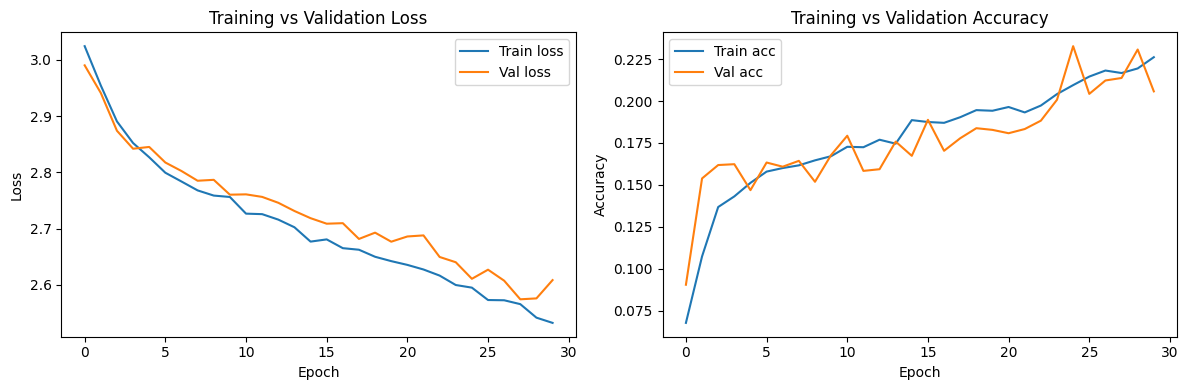

In [48]:
plt.figure(figsize=(12, 4))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train acc')
plt.plot(history.history['val_accuracy'], label='Val acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

Đánh giá trên tập test

In [ ]:
# Dự đoán
y_prob = lenet.predict(test_generator)
y_pred = np.argmax(y_prob, axis=1)
y_true = test_generator.classes  # Label gốc từ generator

# Tính các độ đo
acc = accuracy_score(y_true, y_pred)
precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(
    y_true, y_pred, average='macro', zero_division=0
)

print(f"Accuracy       : {acc:.4f}")
print(f"Precision macro: {precision_macro:.4f}")
print(f"Recall macro   : {recall_macro:.4f}")
print(f"F1-score macro : {f1_macro:.4f}")

209/209 [==============================] - 53s 251ms/step
Accuracy       : 0.2441
Precision macro: 0.2009
Recall macro   : 0.1889
F1-score macro : 0.1497


Kiểm tra tổng xác suất của lớp Softmax

In [50]:
# Lấy 5 mẫu bất kỳ trên tập test
probs_sample = y_prob[:5]   # y_prob đã được tính ở Cell 9
sums = probs_sample.sum(axis=1)

print("Vector xác suất cho 1 mẫu (5 lớp đầu):")
print(probs_sample[0][:5])

print("\nTổng xác suất từng mẫu:")
print(sums)

# Kiểm tra gần bằng 1 trong sai số cho phép
import numpy as np
print("\nTất cả tổng xác suất ≈ 1 ?",
      np.allclose(sums, np.ones_like(sums), atol=1e-6))

Vector xác suất cho 1 mẫu (5 lớp đầu):
[0.04858931 0.09562457 0.01828043 0.02615296 0.04777302]

Tổng xác suất từng mẫu:
[1.        1.0000001 1.        1.        1.       ]

Tất cả tổng xác suất ≈ 1 ? True


Báo cáo chi tiết theo từng lớp

In [51]:
print(classification_report(
    y_true,
    y_pred,
    target_names=class_names,
    digits=4
))

                  precision    recall  f1-score   support

        banh-can     0.5000    0.0041    0.0082       241
        banh-hoi     0.2198    0.2669    0.2411       607
    banh-mi-chao     0.1429    0.0138    0.0252       289
        banh-tet     0.1349    0.1731    0.1516       364
 banh-trang-tron     0.1905    0.0129    0.0242       309
          banh-u     0.3333    0.0057    0.0112       176
        banh-uot     0.1934    0.3643    0.2526       560
       bap-nuong     0.0000    0.0000    0.0000       143
          bo-kho     0.2834    0.1568    0.2019       338
       bo-la-lot     0.3129    0.8581    0.4586       458
       bot-chien     0.0000    0.0000    0.0000       276
           ca-ri     0.0000    0.0000    0.0000       171
    canh-kho-qua     0.4052    0.5897    0.4803       290
   canh-khoai-mo     0.0000    0.0000    0.0000       198
        ga-nuong     0.1876    0.4328    0.2618       372
          goi-ga     0.2270    0.1103    0.1485       290
          ha-

c:\Users\NGAN\anaconda3\envs\tf-env\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\NGAN\anaconda3\envs\tf-env\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\NGAN\anaconda3\envs\tf-env\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape